In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import skimage.transform as trans
from skimage.io import imread, imsave

from preprocess import extract, preprocess, test_train_split

import warnings
warnings.filterwarnings("ignore")

# (1) Extract from LIDC_IDRI raw dataset

In [2]:
# 1.1: clear out old data
shutil.rmtree('data/extracted')

In [3]:
# # 1.2: download from s3
# extract('../raw_data/', 'data/extracted')

Extracting...1010/1010
Complete.


642


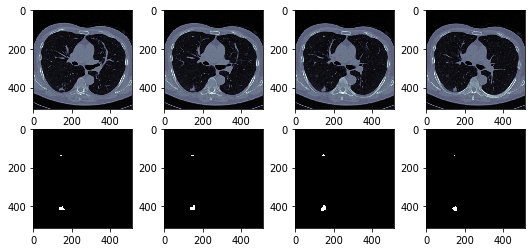

In [4]:
# 1.3: visualize

idx = np.random.randint(len(os.listdir('data/extracted')))
f = os.listdir('data/extracted')[idx]

img, mask, _, _ = pkl.load(open(f'data/extracted/{f}', 'rb'))

print(idx)

fig, axs = plt.subplots(2, 4, figsize=(9, 4))
for i in range(4):
    axs[0][i].imshow(np.array(img[i]), cmap='bone')
    axs[1][i].imshow(np.array(mask[i]), cmap='bone')


plt.show()

# (2) Preprocess

In [5]:
# 2.1: clear out old data
shutil.rmtree('data/processed')

In [6]:
# 2.2 process
preprocess('data/extracted', 'data/processed')

Processing...1890/1890
Complete.


1568


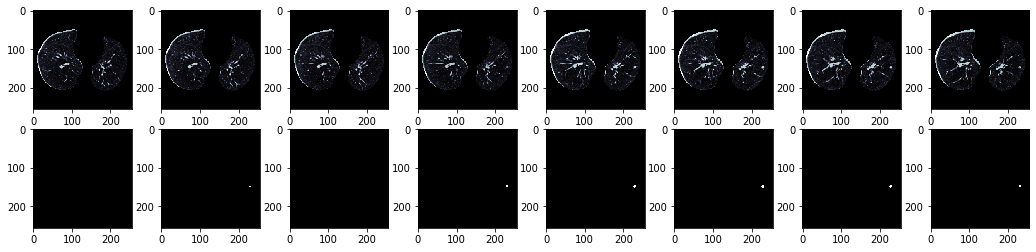

In [7]:
# 2.3: visualize

idx = np.random.randint(len(os.listdir('data/processed/image1')))
# idx = 0
print(idx)

fig, axs = plt.subplots(2, 8, figsize=(18, 4))
for i in range(8):
    img = imread(f'data/processed/image{i}/{idx}.tif') 
    mask = imread(f'data/processed/label{i}/{idx}.tif') 
    axs[0][i].imshow(np.array(img), cmap='bone')
    axs[1][i].imshow(np.array(mask), cmap='bone')

plt.show()

# (3) Remove bad Images

Number of bad images: 84
1615.tif


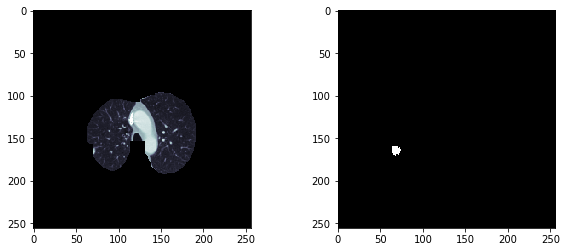

In [8]:
bad_ims = set()
for i in range(4):
    for idx in os.listdir(f'data/processed/image{i}'):
        im = imread(f'data/processed/image{i}/{idx}') 
        mask = imread(f'data/processed/label{i}/{idx}') 
        mask_pixels = im.flatten()[np.argwhere(mask.flatten()>0)]
        # remove if < 50% of mask in image
        if np.count_nonzero(mask_pixels) < (5/10)*mask_pixels.size:
            bad_ims.add(idx)
        else:
            mask = imread(f'data/processed/label{i}/{idx}') 
            mask_pixels = im.flatten()[np.argwhere(mask.flatten()>0)]
            if np.count_nonzero(mask_pixels) < (5/10)*mask_pixels.size:
                bad_ims.append(idx)

bad_ims = list(bad_ims)
                          
print(f"Number of bad images: {len(bad_ims)}")

# visualize bad images
bad_idx = bad_ims[np.random.randint(len(bad_ims))]
bad_img = imread(f'data/processed/image{1}/{bad_idx}') 
bad_mask = imread(f'data/processed/label{1}/{bad_idx}') 

print(bad_idx)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(bad_img), cmap='bone')
axs[1].imshow(np.array(bad_mask), cmap='bone')
plt.show()

In [9]:
for bad_im in bad_ims:
    for i in range(8):
        os.remove(f'data/processed/image{i}/{bad_im}')
        os.remove(f'data/processed/label{i}/{bad_im}')

# (4) Split into test and train

In [10]:
# 3.1: clear out old data
shutil.rmtree('data/train')
shutil.rmtree('data/test')

In [11]:
# 3.2: split
test_train_split('data/processed', 'data/train', 'data/test')

17


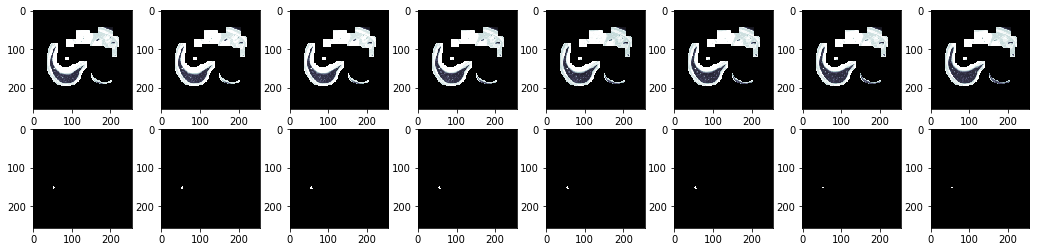

In [15]:
# 3.3a: visualize train

idx = np.random.randint(len(os.listdir('data/train/image1')))
# idx = 0
print(idx)

fig, axs = plt.subplots(2, 8, figsize=(18, 4))
for i in range(8):
    img = imread(f'data/train/image{i}/{idx}.tif') 
    mask = imread(f'data/train/label{i}/{idx}.tif') 
    axs[0][i].imshow(np.array(img), cmap='bone')
    axs[1][i].imshow(np.array(mask), cmap='bone')

plt.show()

26


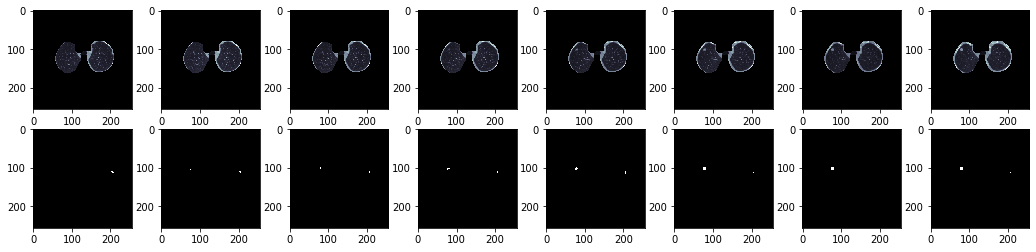

In [13]:
# 3.3b: visualize test

idx = np.random.randint(len(os.listdir('data/test/image1')))
# idx = 0
print(idx)

fig, axs = plt.subplots(2, 8, figsize=(18, 4))
for i in range(8):
    img = imread(f'data/test/image{i}/{idx}.tif') 
    mask = imread(f'data/test/label{i}/{idx}.tif') 
    axs[0][i].imshow(np.array(img), cmap='bone')
    axs[1][i].imshow(np.array(mask), cmap='bone')

plt.show()

# (5) Create Validation split

In [14]:
shutil.rmtree('data/val')
os.mkdir('data/val')
for i in range(8):
    os.mkdir(f'data/val/image{i}')
    os.mkdir(f'data/val/label{i}')

In [15]:
idxs = os.listdir('data/train/image0')
n = len(idxs)
for idx in idxs[n-50:]:
    for i in range(8):
        img = imread(f'data/train/image{i}/{idx}')
        mask = imread(f'data/train/label{i}/{idx}')
        imsave(f'data/val/image{i}/{idx}', im)
        imsave(f'data/val/label{i}/{idx}', mask)
        os.remove(f'data/train/image{i}/{idx}')
        os.remove(f'data/train/label{i}/{idx}')